When a stray animal is brought to a shelter, it is not always apparent what their breed is. Either an expert must assess the animal to determine its breed, or the staff on hand simply guess, sometimes labelling them as "mixed breed" when no primary category is apparent. We believe that having an accurately labelled breed is important for boosting an animal's chance of adoption, and automating the process would save experts' time and allow shelters without easy access to one the ability to confidently label their breeds. We decided to make a classifier for dog breeds to narrow the scope of the problem to one that could be easily solved by a classifier.

The dataset we'll be using to train our classifier comes from the Petfinder API, which takes data from petfinder.com, which is a website that aggregates pet information from animal shelters. Their API allows the client to search for and retrieve pet listings based on characteristics of an animal. To get our data, we just asked it for all animals and filtered out the ones that weren't dogs. The responses have many properties, but we reduced it to the ones we felt would be most useful to the classifier. Some of the properties we removed were things like media links, or references to other animals or organizations from the API.

In [1]:
import pandas as pd
import numpy as np
import sqlite3 as lite
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

*Setup*

We stored the data from the API in a SQL databse, so here we retrieve that info into a DataFrame. 

In [2]:
conn = lite.connect('pets.db')
data = pd.read_sql_query('SELECT * FROM pet', conn)
data

,id,mixed_breed,primary_color,secondary_color,tertiary_color,age,size,gender,coat,good_with_children,good_with_other_dogs,good_with_cats,unknown_breed,primary_breed,secondary_breed
0,1,1,Yellow / Tan / Blond / Fawn,None,None,Young,Small,Female,Medium,1.0,1.0,1.0,0,Terrier,None
1,2,0,None,None,None,Baby,Small,Male,Short,1.0,1.0,1.0,0,Chihuahua,None
2,3,1,Yellow / Tan / Blond / Fawn,None,None,Adult,Medium,Female,Short,NaN,NaN,NaN,0,Golden Retriever,Shepherd
3,4,0,None,None,None,Baby,Small,Female,Short,1.0,1.0,1.0,0,Chihuahua,None
4,5,1,Yellow / Tan / Blond / Fawn,None,None,Adult,Medium,Female,None,1.0,1.0,NaN,0,Retriever,Hound
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13177,13178,1,None,None,None,Young,Large,Female,None,NaN,NaN,NaN,0,Boxer,Mixed Breed
13178,13179,1,None,None,None,Adult,Large,Male,None,NaN,NaN,NaN,0,German Shepherd Dog,None
13179,13180,1,None,None,None,Adult,Large,Male,None,NaN,NaN,NaN,0,Boxer,Mixed Breed
13180,13181,0,None,None,None,Adult,Medium,Male,None,NaN,NaN,NaN,0,Bullmastiff,None


*Data exploration*

The first thing we looked at was the distribution of our data. The classes seem to have a long tail 1 count instances (1/5 of classes) and be heavily concentrated at the head, which would suggest a Zipf distribution. There are also close to 200 different classes.

We also looked at the distribution of the columns.  We noticed that some of the non-binary categorical data such as the three colors columns had significant percentages of NA values, which we tried to fix in feature engineering.




In [26]:
print_counts = lambda counts: print('***', counts.name, '***\n', \
                                    counts, '\n' \
                                   '% filled:', counts.sum() / data.shape[0] * 100, '\n')

data.apply(lambda col: print_counts(col.value_counts()))
print('Breeds with 1 instance', data['primary_breed'].value_counts().apply(lambda c: 1 if c == 1 else 0).sum())

*** age ***
 Adult     6088
Young     3695
Baby      2535
Senior     864
Name: age, dtype: int64 
% filled: 100.0 

*** size ***
 Medium         6448
Large          3576
Small          2921
Extra Large     237
Name: size, dtype: int64 
% filled: 100.0 

*** gender ***
 Male      7008
Female    6174
Name: gender, dtype: int64 
% filled: 100.0 

*** coat ***
 Short       12033
Medium        858
Long          207
Wire           48
Curly          35
Hairless        1
Name: coat, dtype: int64 
% filled: 100.0 

*** good_with_children ***
 1.0    12675
0.0      507
Name: good_with_children, dtype: int64 
% filled: 100.0 

*** good_with_other_dogs ***
 1.0    12785
0.0      397
Name: good_with_other_dogs, dtype: int64 
% filled: 100.0 

*** good_with_cats ***
 1.0    12390
0.0      792
Name: good_with_cats, dtype: int64 
% filled: 100.0 

*** primary_breed ***
 Pit Bull Terrier           1604
Labrador Retriever         1482
Chihuahua                   934
Mixed Breed                 911
Terri

Data cleaning:

We clean the data by setting all NA values to the mode for that column, except for secondary and tertiary color, which we explain below. We also drop the 'id' column and any of the columns which related to the breed other than `primary_breed` to prevent the classifier from cheating. We chose mode because all of our data is categorical, and there's too many NA values to make dropping rows viable, and we only have a few columns so we wanted to preserve as many as we could. 

In [4]:
fill_mode = lambda col: col.fillna(col.mode()[0])

data_cleaned = data.drop(['id', 'secondary_color', 'tertiary_color', 'secondary_breed', 'unknown_breed', 'mixed_breed'], axis=1) \
.apply(fill_mode, axis=0) \
.join(data[['secondary_color', 'tertiary_color']])

data_cleaned

,primary_color,age,size,gender,coat,good_with_children,good_with_other_dogs,good_with_cats,primary_breed,secondary_color,tertiary_color
0,Yellow / Tan / Blond / Fawn,Young,Small,Female,Medium,1.0,1.0,1.0,Terrier,None,None
1,Black,Baby,Small,Male,Short,1.0,1.0,1.0,Chihuahua,None,None
2,Yellow / Tan / Blond / Fawn,Adult,Medium,Female,Short,1.0,1.0,1.0,Golden Retriever,None,None
3,Black,Baby,Small,Female,Short,1.0,1.0,1.0,Chihuahua,None,None
4,Yellow / Tan / Blond / Fawn,Adult,Medium,Female,Short,1.0,1.0,1.0,Retriever,None,None
...,...,...,...,...,...,...,...,...,...,...,...
13177,Black,Young,Large,Female,Short,1.0,1.0,1.0,Boxer,None,None
13178,Black,Adult,Large,Male,Short,1.0,1.0,1.0,German Shepherd Dog,None,None
13179,Black,Adult,Large,Male,Short,1.0,1.0,1.0,Boxer,None,None
13180,Black,Adult,Medium,Male,Short,1.0,1.0,1.0,Bullmastiff,None,None


Feature Engineering:

We did our feature engineering on the colors columns. Of these, only `primary_color` had enough data to be useful, but we still wanted to make use of the extra columns. If we filled the secondary and tertiary colors with mode, we still had garbage data because around 90% of the rows would have the same value. Instead, we decided to try and count the number of colors and place that in a new column, `color_count`. While doing this, we noticed that the data in the color fields lists multiple values, but since the data is a string, it's all treated as one value. We fixed this by splitting the string into lists of the different colors listed, and removing `None` values. This let us get a more accurate `color_count` and will help us with encoding the data later. Finally, we combined the three color columns into `colors`, which lists the union of the lists in `primary_color`, `secondary_color`, and `tertiary_color`. We did this because of how sparse `secondary_color` and `tertiary_color` were, such that they weren't useful on their own. Combining the three allowed us get rid of the sparse features without throwing away their data.

We also tried adding more columns such as `breed_counts` and `breed_group`, which we found massively increased our accuracy. We then realized that by relating these columns to the labels, we were indirectly giving the answers to the classifier. Also, in a real world usage of the classifier we wouldn't be able to determine these properties for animals with an unknown breed, so they were useless anyway.

In [5]:
data = data_cleaned

split_colors = lambda index: data[index].astype(str).apply(lambda s: s.split(' / ')).apply(lambda o: [i for i in o if not str(i) == 'None']) 

data_engineered = data

data_engineered['colors'] = (split_colors('primary_color') \
                  + split_colors('secondary_color') \
                  + split_colors('tertiary_color') \
                 ).apply(lambda o: np.unique(o))

data_engineered['color_count'] = data_engineered['colors'].apply(lambda o: len(o))

data = data_engineered.drop(['primary_color', 'secondary_color', 'tertiary_color'], axis=1)
"""
"Cheating" code for breed groups.
data['breed_counts'] = data['primary_breed'].apply(lambda x: 1 if x else 0) + data['secondary_breed'].apply(lambda x: 1 if x else 0)
data['Mixed'] = data['primary_breed'].apply(lambda x: 1 if x=='Labrador Retriever' or x=='Husky' else 0)
data['Terrier'] = data['primary_breed'].apply(lambda x: 1 if x=='Pit Bull Terrier' or x=='Terrier' or x=='American Staffordshire Terrier' or x=='Staffordshire Bull Terrier' or x=='Jack Russell Terrier' or x=='Cairn Terrier' or x=='Border Terrier' else 0)
data['Toy'] = data['primary_breed'].apply(lambda x: 1 if x=='Chihuahua' or x=='Shih Tzu' or x =='Miniature Pinscher' or x=='Parson Russell Terrier' or x=='Rat Terrier' or x=='Maltese' or x=='Pug' or x=='Yorkshire Terrier' else 0)
data['Herding'] = data['primary_breed'].apply(lambda x: 1 if x=='German Shepherd Dog' or x=='Shepherd' or x=='Border Collie' or x=='Australian Cattle Dog / Blue Heeler' or x=='Catahoula Leopard Dog' or x=='Australian Shepherd' or x=='Cattle Dog' or x=='Corgi' or x=='Collie' or x=='Belgian Shepherd / Malinois' else 0)
data['Working'] = data['primary_breed'].apply(lambda x: 1 if x=='Boxer' or x=='Siberian Husky' or x=='American Bulldog' or x=='Great Pyrenees' or x=='Doberman Pinscher' or x=='Schnauzer' or x=='Rottweiler' or x=='Mastiff' or x=='Akita' or x=='Alaskan Malamute' or x=='Newfoundland Dog' else 0)
data['Hound'] = data['primary_breed'].apply(lambda x: 1 if x=='Beagle' or x=='Hound' or x=='Dachshund' or x=='Basset Hound' or x=='Plott Hound' or x=='Treeing Walker Coonhound' or x=='Coonhound' or x=='Basenji' else 0)
data['Non-sporting'] = data['primary_breed'].apply(lambda x: 1 if x=='Poodle' or x=='American Eskimo Dog' or x=='Boston Terrier' else 0)
data['Sporting'] = data['primary_breed'].apply(lambda x: 1 if x=='Golden Retriever' or x=='Pointer' or x=='Retriever' or x=='Black Labrador Retriever' or x=='Cocker Spaniel' else 0)
data['Hound'] = data['primary_breed'].apply(lambda x: 1 if x=='Greyhound' else 0)
"""

data_engineered[['primary_color', 'secondary_color', 'tertiary_color', 'colors', 'color_count']]

,primary_color,secondary_color,tertiary_color,colors,color_count
0,Yellow / Tan / Blond / Fawn,None,None,"[Blond, Fawn, Tan, Yellow]",4
1,Black,None,None,[Black],1
2,Yellow / Tan / Blond / Fawn,None,None,"[Blond, Fawn, Tan, Yellow]",4
3,Black,None,None,[Black],1
4,Yellow / Tan / Blond / Fawn,None,None,"[Blond, Fawn, Tan, Yellow]",4
...,...,...,...,...,...
13177,Black,None,None,[Black],1
13178,Black,None,None,[Black],1
13179,Black,None,None,[Black],1
13180,Black,None,None,[Black],1


Now we do some more cleaning to fix our unbalanced sample (Zipfian distribution of classes). We used random oversampling to fix this because fancier methods are more geared towards continuous data. Next we encode the data in two ways. We first convert the `colors` column to a one-hot encoding using dummy features. Next, we ensure all our data is encoded as integers since it is all categorical, which is partially just to make the output cleaner.

In [104]:
Y = data['primary_breed']
X = data.drop(['primary_breed'], axis=1)

# ros 
counts = Y.value_counts()
sample_threshold = counts[0] // 10
minorities = counts[counts.values < sample_threshold]

ros = RandomOverSampler(sampling_strategy={ key: sample_threshold for key in minorities.index })
X_ros, Y_ros = ros.fit_sample(X, Y)

# encoding
gle = LabelEncoder()
encode_field = lambda df, field: df.drop(field, axis=1).join(pd.DataFrame(gle.fit_transform(df[field]), columns=[field]))

X_encoded = X_ros.drop('colors', axis=1).join(X_ros['colors'].str.join('|').str.get_dummies())
X_encoded = encode_field(X_encoded, 'age')
X_encoded = encode_field(X_encoded, 'size')
X_encoded = encode_field(X_encoded, 'gender')
X_encoded = encode_field(X_encoded, 'coat')
X_encoded = X_encoded.apply(lambda col: col.astype('int32'), axis=0)

X = X_encoded
Y = Y_ros

X

# X_train, X_test, Y_train, Y_test = train_test_split(X_encoded, Y_ros, test_size=0.2)

,good_with_children,good_with_other_dogs,good_with_cats,color_count,Apricot,Beige,Bicolor,Black,Blond,Blue,...,Sable,Silver,Tan,"Tricolor (Brown, Black, & White)",White,Yellow,age,size,gender,coat
0,1,1,1,4,0,0,0,0,1,0,...,0,0,1,0,0,1,3,3,0,3
1,1,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,3,1,4
2,1,1,1,4,0,0,0,0,1,0,...,0,0,1,0,0,1,0,2,0,4
3,1,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,3,0,4
4,1,1,1,4,0,0,0,0,1,0,...,0,0,1,0,0,1,0,2,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38119,1,1,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,2,3,0,2
38120,1,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,3,3,1,4
38121,1,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,3,3,0,4
38122,1,1,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,3,1,3


*Classification*

Now, we're ready to try classifying the data. We used a decision tree for its inherent ability to handle multiclass classification and tuned it with some pre-pruning. When looking at the documentation, we saw that gini is intended for continuous attributes, so we chose entropy as our critereon. The hyperparameters we chose were some of the ones we learned about in class that seemed like they'd be good to avoid overfitting, which is especially dangerous with such a high number of different classes. We got the param values by looking at the properties of a single decision tree fitted to the data.

When we look at our accuracy, 46% seems a little low at first, but considering that we have 200 classes, and random guessing's accuracy would come out to about 0.5%, this seems like a pretty decent amount. Without the grid search, our accuracy is 10-15% lower, so the tuning definitely helps. We decided to look at balanced accuray instead of accuracy for this step because we are using a fairly unbalanced dataset and it accounts for that in its rating.

In [105]:
params = {'max_depth': range(15, 35, 5),
          'max_features': range(1, X.shape[1],  X.shape[1] // 4),
          'min_samples_leaf': [1, 5, 10, 25, 50]}

tree = DecisionTreeClassifier(criterion="entropy")
grid_search = GridSearchCV(tree, params, cv=5, scoring='balanced_accuracy')

Y_pred = cross_val_predict(grid_search, X, Y)

print("Tree accuracy:", balanced_accuracy_score(Y, Y_pred) * 100.0)

Tree accuracy: 46.11531707158868


*Analysis*

To further analyze our results we created a classification report of our findings, including precision, recall, and the f1-score. 

For our precision, there is a weight average of 60%. For recall, there is a weighted average of 46%. Since we have much higher precision than recall, that means that our model generally prioritizes returning correct postive predictions of instances over correctly classifying all positive instances of a class. In the context of our problem, it is desirable to have a high precision because we want to ensure more positive cases of a breed are correctly classified as positive. If someone came in to adopt a certain breed, we would certainly want to maximize the number of true predictions of that breed they could choose from, otherwise they would be very confused when they came in to adopt a pet labeled as a "Dachshund" when in fact they came to meet a dog closer to a "Dalmatian".

Our f1-score summarizes the precision and recall into an overall weighted average score of 46%, which consistent with our accuracy. Given that there is a total of 197 distinct breeds, this f1-score is acceptable.

Looking into the specifics, the minority classes are clearly very inconsistent. Breeds like the Samoyed and the Aussiedoodle are predicted at near-perfection, while other such as the Nova Scotia Duck Tolling Retriever and Borzoi show 0s across the board. This is likeley a side-effect of random oversampling from some very small pools with a decision tree, as all of the duplicated items will end up at the same leaf.

In [106]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report

cm = classification_report(Y, Y_pred)
print(cm)

C:\Users\Connor\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                          precision    recall  f1-score   support

                           Affenpinscher       0.13      0.42      0.20       160
                            Afghan Hound       1.00      1.00      1.00       160
                        Airedale Terrier       1.00      0.26      0.41       160
                                  Akbash       0.98      1.00      0.99       160
                                   Akita       0.70      0.24      0.36       160
                        Alaskan Malamute       0.75      0.51      0.61       160
                        American Bulldog       0.06      0.01      0.02       233
                          American Bully       0.55      0.72      0.62       160
                     American Eskimo Dog       0.91      0.49      0.63       160
                       American Foxhound       0.63      0.73      0.67       160
          American Staffordshire Terrier       0.12      0.03      0.05       413
               

We created confusion matrices for the top 5 most and least occuring breeds in our dataset. For the least occurring this is essentially a sample of the minority classes as we oversampled them to all have the same counts. 

From these matrices, you can see that our precision on the top breeds ranges from about 10% to 50%, while among the minority dogs the precision looks a bit higher on average. As one might expect, we tend to overpredict the majority classes, which means we underpredict some of the minority classes. However, recall actually looks better on the minority classes. False negatives run fairly high across the board, which makes sense given that the task of always identifying a dog breed is much harder than being able to correctly determine if a dog is of that breed.

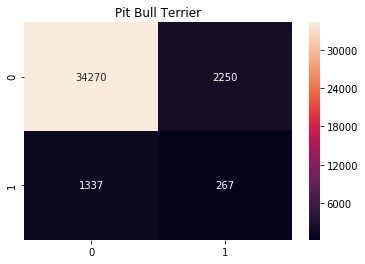

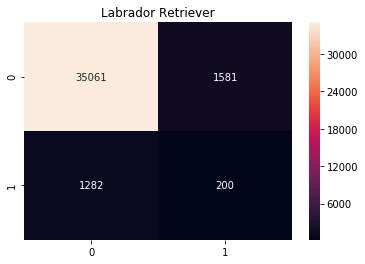

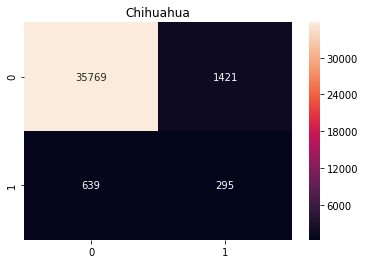

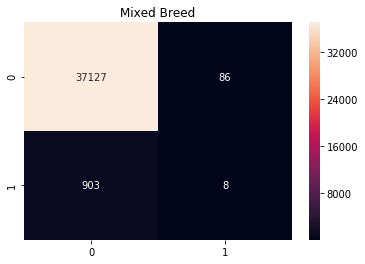

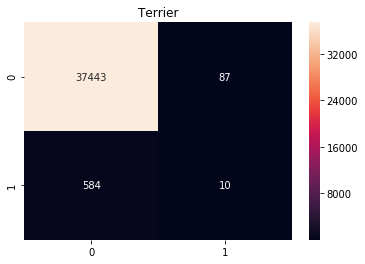

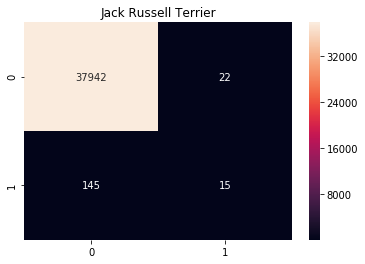

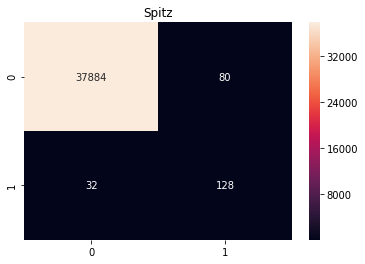

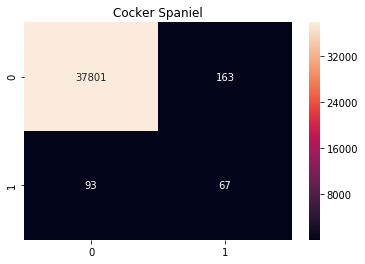

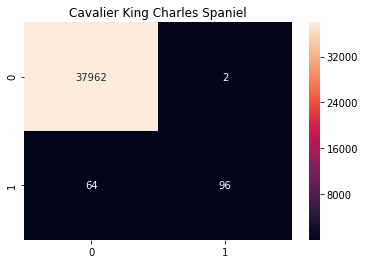

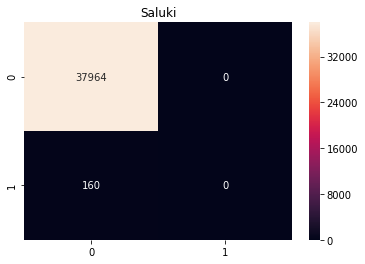

In [108]:
top_bot_breeds = Y.value_counts()[:5].keys().append(Y.value_counts()[-5:].keys())
mcm = multilabel_confusion_matrix(Y, Y_pred, labels=top_bot_breeds)
for i in range(len(top_bot_breeds)):
    plt.figure()
    ax = sn.heatmap(mcm[i], annot=True, fmt='g')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_title(top_bot_breeds[i])

*Conclusion*

Our metrics seem alright for such a hard classification problem, but it would still ideally be much better for use in the real world. Tuning hyperparameters seemed to have a significant impact on the accuracy, so if we had a faster computer we could experiment with more parameters and values in our grid search. Another thing that would help would be to have more continuous attributes, as our data was entirely categorical to start with, even though it has attributes like "height" and "weight" that could have been much more specific. A more precise/detailed data source with a few more attributes and more quantitative data would probably help, since we only have 11 features to work with after engineering. One last thing would be to make our dataset more balanced. If we used a min instances threshold we could probably get a more accurate classifier, but it would come at he cost of robustness. In fact, being able to classify breeds that appear less in this dataset is likely more valuable for shelters, as rarity in a shelter can be an indicator of high demand, and a shelter would want to know accuratley when they can advertise an in-demand breed. A solution to this might be to cluster the breeds, then build a classifier for each cluster, and cluster each new instance to determine which classifier to use.